In [1]:
import sys
import pickle
sys.path.append('../')
from models.xgboost.xgboost import F1XGBoostPredictor

In [2]:
# Load your processed data
with open('processed_race_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

# Initialize and optimize
predictor = F1XGBoostPredictor(processed_data)
study = predictor.optimize(n_trials=500)

# Train the model with best parameters
predictor.train(study)

# Evaluate performance
metrics = predictor.evaluate()
print(f"Test RMSE: {metrics['rmse']:.2f} ms")
print(f"Test MAE: {metrics['mae']:.2f} ms")

# Save the model
predictor.save_model('f1_xgboost_model.json')

[I 2024-12-07 23:49:37,876] A new study created in memory with name: no-name-f81e5f09-ba78-4a96-83e2-6981aec8c3ed
[I 2024-12-07 23:49:38,772] Trial 0 finished with value: 4410.07722926603 and parameters: {'max_depth': 5, 'learning_rate': 0.061756841795033664, 'n_estimators': 207, 'min_child_weight': 5, 'subsample': 0.8961097326110841, 'colsample_bytree': 0.9425448265614265, 'reg_alpha': 1.2709132698677809e-05, 'reg_lambda': 0.002200950318775049}. Best is trial 0 with value: 4410.07722926603.
[I 2024-12-07 23:49:40,659] Trial 1 finished with value: 4822.45476683436 and parameters: {'max_depth': 12, 'learning_rate': 0.030795472098908323, 'n_estimators': 100, 'min_child_weight': 4, 'subsample': 0.9225984686522689, 'colsample_bytree': 0.9115386777846175, 'reg_alpha': 3.1417307024090007e-07, 'reg_lambda': 5.242601343947867e-07}. Best is trial 0 with value: 4410.07722926603.
[I 2024-12-07 23:49:52,725] Trial 2 finished with value: 4901.891037384578 and parameters: {'max_depth': 12, 'learning

Test RMSE: 3731.07 ms
Test MAE: 2551.16 ms


/var/folders/c3/96l18xtx7fz9rgy3dxg2crdm0000gn/T/ipykernel_3427/3752894574.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = spearmanr(features[:, i], targets)
/var/folders/c3/96l18xtx7fz9rgy3dxg2crdm0000gn/T/ipykernel_3427/3752894574.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(subset_features[:, i], subset_targets)


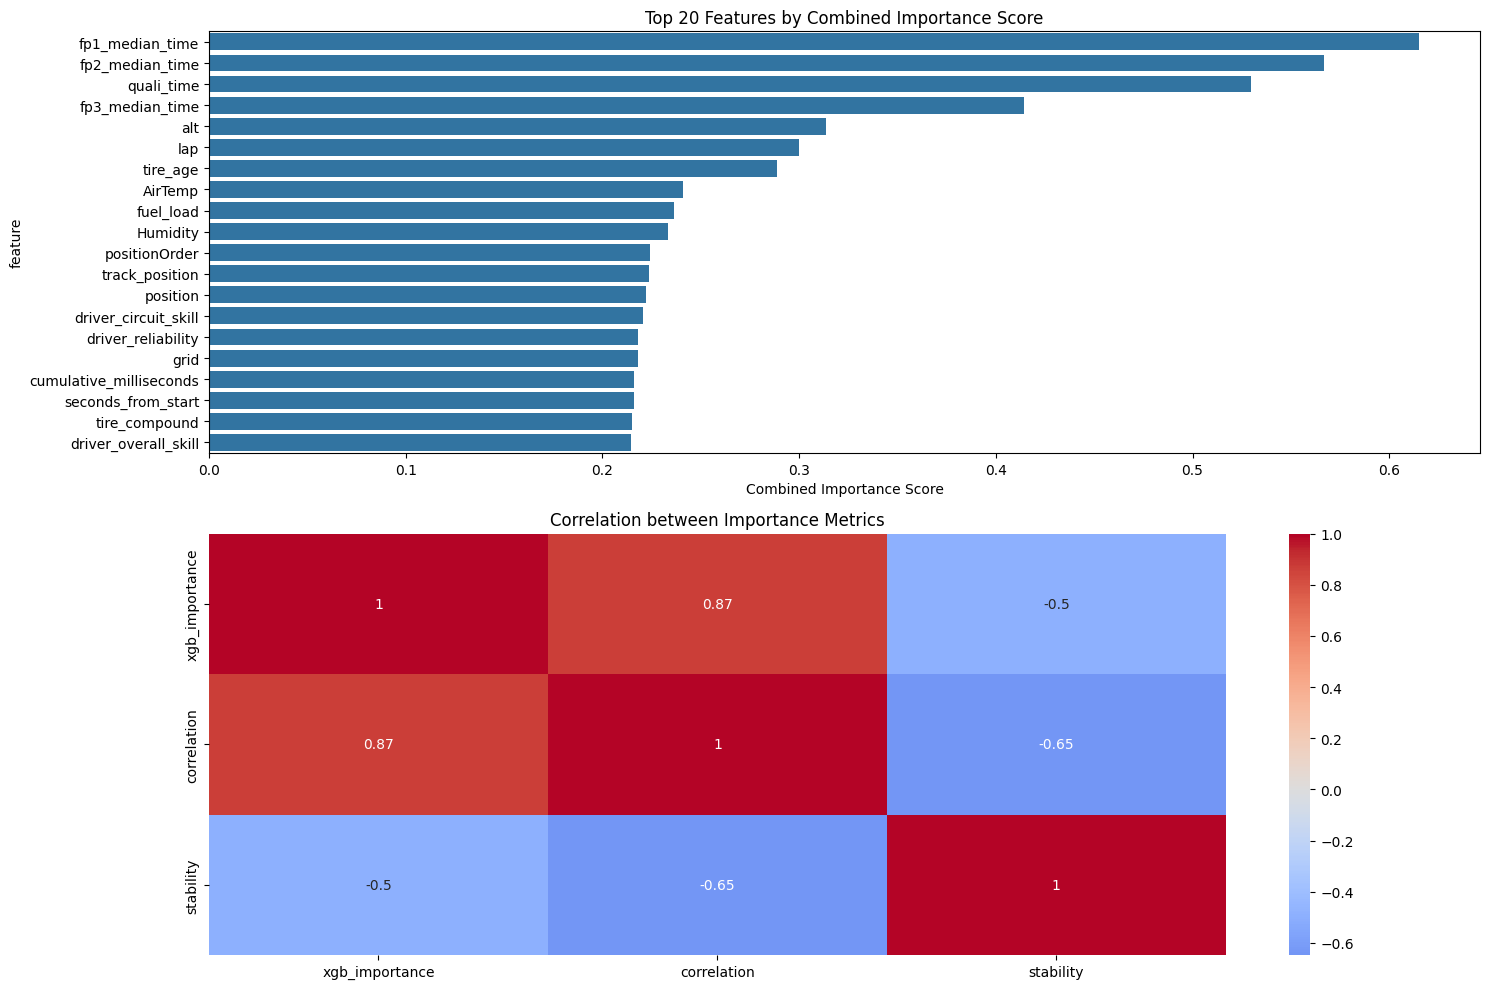


Recommended features to keep:
- fp1_median_time
- fp2_median_time
- quali_time
- fp3_median_time
- alt
- lap
- tire_age
- AirTemp
- fuel_load
- Humidity
- positionOrder
- track_position
- position
- driver_circuit_skill
- driver_reliability
- grid
- cumulative_milliseconds
- seconds_from_start
- tire_compound
- driver_overall_skill
- constructor_position
- constructor_nationality_American
- constructor_performance
- constructor_nationality_Austrian
- GapToLeader_ms
- driver_consistency
- constructor_nationality_German
- TrackTemp
- constructor_nationality_Italian
- constructor_nationality_French
- constructorId
- constructor_nationality_British
- constructor_nationality_Swiss
- constructor_nationality_Indian
- IntervalToPositionAhead_ms
- driver_risk_taking
- driver_aggression
- driver_adaptability
- circuit_type_encoded

Features to consider removing:



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from typing import Dict, List, Tuple

def analyze_feature_importance(predictor, processed_data: Dict) -> Dict:
    """
    Comprehensive feature importance analysis using multiple methods.
    
    Args:
        predictor: Trained XGBoost predictor
        processed_data: Dictionary containing processed feature data
    
    Returns:
        Dictionary containing various feature importance metrics
    """
    # Get feature names
    feature_names = predictor.static_features + predictor.dynamic_features
    
    # Get feature importance from XGBoost
    xgb_importance = predictor.model.feature_importances_
    
    # Calculate correlation with target
    features = processed_data['train']['features']
    targets = processed_data['train']['targets']
    
    # Calculate Spearman correlation for each feature
    correlations = []
    for i in range(features.shape[1]):
        correlation, _ = spearmanr(features[:, i], targets)
        correlations.append(abs(correlation))  # Use absolute correlation
    
    # Calculate feature stability (variance across different subsets)
    n_splits = 5
    split_size = len(features) // n_splits
    stability_scores = []
    
    for i in range(features.shape[1]):
        importances = []
        for j in range(n_splits):
            start_idx = j * split_size
            end_idx = (j + 1) * split_size
            subset_features = features[start_idx:end_idx]
            subset_targets = targets[start_idx:end_idx]
            
            # Calculate correlation for this subset
            corr, _ = spearmanr(subset_features[:, i], subset_targets)
            importances.append(abs(corr))
        
        stability_scores.append(1 - np.std(importances))
    
    # Combine all metrics
    feature_metrics = []
    for i, feature_name in enumerate(feature_names):
        feature_metrics.append({
            'feature': feature_name,
            'xgb_importance': xgb_importance[i],
            'correlation': correlations[i],
            'stability': stability_scores[i],
            # Combined score giving equal weight to all metrics
            'combined_score': (
                0.4 * xgb_importance[i] + 
                0.4 * correlations[i] + 
                0.2 * stability_scores[i]
            )
        })
    
    return pd.DataFrame(feature_metrics).sort_values('combined_score', ascending=False)

def plot_feature_importance(importance_df: pd.DataFrame, top_n: int = 20):
    """
    Create visualizations for feature importance analysis.
    
    Args:
        importance_df: DataFrame containing feature importance metrics
        top_n: Number of top features to display
    """
    plt.figure(figsize=(15, 10))
    
    # Plot top features by combined score
    top_features = importance_df.head(top_n)
    
    plt.subplot(2, 1, 1)
    sns.barplot(data=top_features, x='combined_score', y='feature')
    plt.title(f'Top {top_n} Features by Combined Importance Score')
    plt.xlabel('Combined Importance Score')
    
    # Plot correlation between different importance metrics
    plt.subplot(2, 1, 2)
    importance_metrics = ['xgb_importance', 'correlation', 'stability']
    correlation_matrix = importance_df[importance_metrics].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between Importance Metrics')
    
    plt.tight_layout()
    plt.show()

def get_feature_recommendations(importance_df: pd.DataFrame, 
                              threshold: float = 0.01) -> Tuple[List[str], List[str]]:
    """
    Provide recommendations for feature selection.
    
    Args:
        importance_df: DataFrame containing feature importance metrics
        threshold: Minimum importance threshold for keeping features
    
    Returns:
        Tuple containing (features to keep, features to consider removing)
    """
    # Features to definitely keep (high importance or correlation)
    keep_features = importance_df[
        (importance_df['combined_score'] > threshold) |
        (importance_df['correlation'] > threshold * 2)
    ]['feature'].tolist()
    
    # Features to consider removing
    remove_features = importance_df[
        (importance_df['combined_score'] <= threshold) &
        (importance_df['correlation'] <= threshold * 2)
    ]['feature'].tolist()
    
    return keep_features, remove_features

# Example usage after optimization:

# Run analysis
importance_df = analyze_feature_importance(predictor, processed_data)

# Plot results
plot_feature_importance(importance_df)

# Get recommendations
keep_features, remove_features = get_feature_recommendations(importance_df)

print("\nRecommended features to keep:")
print("\n".join(f"- {feature}" for feature in keep_features))

print("\nFeatures to consider removing:")
print("\n".join(f"- {feature}" for feature in remove_features))
